# Perovskites

In this notebook, we demonstrate some of the initial work on this project that was carried out in the summer of 2021. Here, we leverage some Xenonpy-calculated properties to calculate the unit cell volume of several perovskite systems taken from NOMAD's database.

Both SISSO and TPOT are used to train predictive models, and near the end of the document we discuss what we can learn from this comparison.

Overall, in this notebook we demonstrate SISSO's ability to generate simple, interpretable models that can help lead us to physical insight - one of the major strengths of symbolic regression.

In [1]:
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tpot
import sklearn

import sys

sys.path.append("../../../")
import DigitalEcosystem.utils.figures

from IPython.display import Latex

# Read in the Data

At this point, we hadn't yet settled on how we would be pipelineing the data. We were storing the mean and standard deviation of the dataset separately in pickled pandas dataframes. So, we'll load in the mean and standard deviation, along with the training / testing set.

In [2]:
mean = pd.read_pickle("./dataset_means_stds/perov_mean.pkl")
std = pd.read_pickle("./dataset_means_stds/perov_std.pkl")
data_train_scaled = pd.read_csv("./scaled_featurized_train/scaled_perovskite_train.csv", index_col=0)
data_test_scaled = pd.read_csv("./scaled_featurized_test/scaled_perovskite_test.csv", index_col=0)
data_train = (data_train_scaled * std) + mean
data_test = (data_test_scaled * std) + mean

# SISSO Models
Here, we have Rung1 and Rung2 models that have been generated by SISSO using the XenonPy compositional descriptors. In all casees, $V$ refers to Volume. We have also explained the features generated by XenonPy as described on their documentation page. [Link to Documentation].(https://xenonpy.readthedocs.io/en/latest/features.html)

## Rung1, 1-Term
$V=c_0+a_0*(VDW\_Radius\_UFF_{avg} + Covalent\_Radius\_Pyykko\_Double_{avg})$

Where:
- $VDW\_Radius\_UFF_{avg}$ is average the Van der Waals radius used by the Universal ForceField (UFF) method.
- $Covalent\_Radius\_Pyykko\_Double_{avg}$ is the average double-bond covalent radius by Pyykko et al.

## Rung1, 2-Term
$V=c_0+a_0*(Num\_P\_Valence_{avg} + Num\_P\_Unfilled_{avg}) + a_1*(GS\_Volume\_Per_{min} + Covalent\_Radius\_Pyykko\_Double_{avg})$

Where:
- $Num\_P\_Valence_{avg}$ is the average number of valence electrons in P orbitals.
- $Num\_P\_Unfilled_{avg}$ is the average number of unfilled valence electrons in the P orbitals.
- $GS\_Volume\_Per_{min}$ is the minimum DFT-calculated volume of the elemental unit cells.
- $Covalent\_Radius\_Pyykko\_Double_{avg}$ is the average double-bond covalent radius by Pyykko et al.

## Rung2, 1-Term
$V=c_0+a_0*((Polarizability_{min}+Num\_P\_Valence_{avg})+(GS\_Volume\_Per_{min}+VDW\_Radius\_MM3_{avg}))$

Where:
- $Polarizability_{min}$ is the minimum polarizability.
- $Num\_P\_Valence_{avg}$ is the average number of valence electrons in P orbitals.
- $GS\_Volume\_Per_{min}$ is the minimum DFT-calculated volume of the elemental unit cells.
- $VDW\_Radius\_M3_{avg}$ is the average Van der Waals radius used by the MM3 forcefield.


In [3]:
models = {
    "r1_1term": lambda df: 2.342082515585748e-02 + \
                           5.172456498122173e-01 * (df["ave:vdw_radius_uff"] + df["ave:covalent_radius_pyykko_double"]),
    "r1_2term": lambda df: 1.052443572291616e-02 + \
                           1.242091145866421e-01 * (df["ave:num_p_valence"] + df["ave:num_p_unfilled"]) + \
                           4.898720001428966e-01 * (df["min:gs_volume_per"] + df["ave:covalent_radius_pyykko_double"]),
    "r2_1term": lambda df: 4.521699008847579e-03 + \
                           2.966651096729857e-01 * (
                                   (df["min:Polarizability"] + df["ave:num_p_valence"]) + \
                                   (df["min:gs_volume_per"] + df["ave:vdw_radius_mm3"])
                           )
}

data_train_scaled_sisso = data_train_scaled.copy()
data_test_scaled_sisso = data_test_scaled.copy()
for key, fun in models.items():
    data_train_scaled_sisso[key] = fun(data_train_scaled_sisso)
    data_test_scaled_sisso[key] = fun(data_test_scaled_sisso)

data_train_scaled_sisso.head()

,Volume,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,ave:c6_gb,ave:covalent_radius_cordero,...,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability,r1_1term,r1_2term,r2_1term
8,0.460560,-0.693693,-0.841394,0.522243,-1.011110,-0.707068,-0.107349,-1.083124,-1.169420,-0.247505,...,-0.502591,0.827300,1.004929,0.756753,-1.926999,-0.947513,0.572126,0.061479,0.354153,0.595211
64,-0.310043,0.195162,-0.071373,-1.159536,0.285985,0.279627,-1.609260,-0.424059,-0.104029,-0.768425,...,-0.280108,-0.918379,-0.906144,-1.011281,-1.347258,0.556856,-0.808481,-0.626768,-0.520439,-0.556789
24,-0.309313,-0.471480,0.414174,-0.725953,0.342844,-0.455014,-1.702234,0.062819,-0.045151,-0.414200,...,-0.293363,-0.606651,-0.693802,-0.471049,0.467286,-0.794189,-0.600072,-0.018909,-0.348400,-0.149942
22,-0.476780,0.461818,-1.354490,-1.015008,-1.149704,0.552693,-0.910713,-0.027642,-1.786160,-1.424785,...,-0.280108,-0.918379,-0.906144,-1.011281,-1.020869,-0.105947,-0.808481,-0.850390,-0.547886,-0.643998
73,-0.246543,-0.093716,0.377718,-0.817925,0.819038,-0.060981,-0.592315,-0.056646,0.891252,-0.414200,...,-0.280108,-0.918379,-0.906144,-1.011281,0.156873,0.439971,-0.808481,0.086907,-0.213818,-0.294630


# TPOT Model

To have something to compare to, we'll also run a TPOT model for 10 minutes.

In [4]:
# TPOT with the vanilla features

model = tpot.TPOTRegressor(
    generations=None,
    population_size=100,
    max_eval_time_mins=1 / 60,
    max_time_mins=10,
    cv=len(data_train_scaled),
    verbosity=2,
    scoring="neg_root_mean_squared_error",
    config_dict=tpot.config.regressor_config_dict,
    n_jobs=-1,
    random_state=1234
)

In [5]:
train_x = data_train_scaled.drop(columns="Volume").to_numpy()
train_y = data_train_scaled.Volume.to_numpy().ravel()

test_x = data_test_scaled.drop(columns="Volume").to_numpy()
test_y = data_test_scaled.Volume.to_numpy().ravel()

model.fit(train_x, train_y)

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.08724802833735586

Generation 2 - Current best internal CV score: -0.08724802833735586

Generation 3 - Current best internal CV score: -0.08724802833735586

Generation 4 - Current best internal CV score: -0.08709296369565332

Generation 5 - Current best internal CV score: -0.08709296369565332

Generation 6 - Current best internal CV score: -0.08709296369565332

Generation 7 - Current best internal CV score: -0.08702438635062623

Generation 8 - Current best internal CV score: -0.08702438635062623

Generation 9 - Current best internal CV score: -0.08702438635062623

Generation 10 - Current best internal CV score: -0.08546263313372582

Generation 11 - Current best internal CV score: -0.08546263313372582

Generation 12 - Current best internal CV score: -0.08546263313372582

Generation 13 - Current best internal CV score: -0.08465318266726941

Generation 14 - Current best internal CV score: -0.08465318266726941

Generation 15 - Current best

TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

## TPOT Pipeline
TPOT Generates the following pipeline:
1. Decision Tree Regressor
2. The decision tree's predictions are scaled to be between 0 and 1.
3. Ridge regression is used on this scaled set of predictions.

## TPOT Model Plot

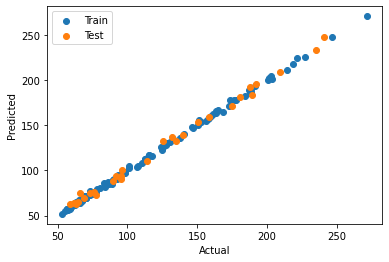

In [6]:
def unscale(arr):
    return arr * std["Volume"] + mean["Volume"]


train_pred_y = model.predict(train_x)
test_pred_y = model.predict(test_x)

create_parity_plot_with_raw_values = functools.partial(DigitalEcosystem.utils.figures.save_parity_plot_with_raw_values,
                                                       train_y=unscale(train_y),
                                                       test_y=unscale(test_y))

create_parity_plot_with_raw_values(unscale(train_pred_y),
                                   unscale(test_pred_y),
                                   filename='tpot_parity.png')

# SISSO Rung1, 1-Term Plot

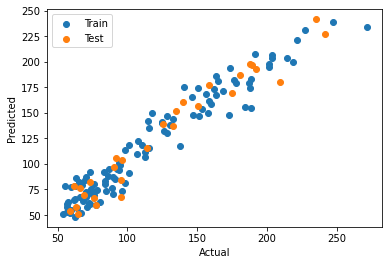

In [7]:
create_parity_plot_with_raw_values(unscale(data_train_scaled_sisso["r1_1term"]),
                                   unscale(data_test_scaled_sisso["r1_1term"]),
                                   filename='sisso_r1_1t_parity.png')

# SISSO Rung1, 2-Term Plot

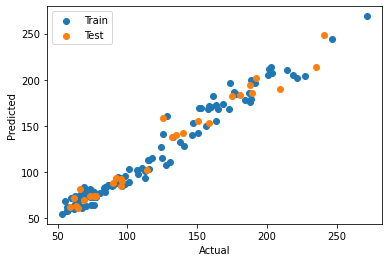

In [8]:
create_parity_plot_with_raw_values(unscale(data_train_scaled_sisso["r1_2term"]),
                                   unscale(data_test_scaled_sisso["r1_2term"]),
                                   filename='sisso_r1_2t_parity.png')

# SISSO Rung2, 1-Term Plot

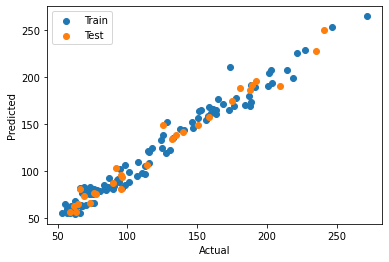

In [9]:
create_parity_plot_with_raw_values(unscale(data_train_scaled_sisso["r2_1term"]),
                                   unscale(data_test_scaled_sisso["r2_1term"]),
                                   filename='sisso_r2_1t_parity.png')

# Combined Plots

Finally, we compare the results of the SISSO models and the TPOT model.

## Training Set

Below, we plot the Training set results for:
1. The TPOT model (Black + symbols)
2. The SISSO Rung1, 1-Term Model (Red Nablas / Upside-Down Triangles)
3. The SISSO Rung1, 2-Term Model (Green Deltas / Rightside-Up Triangles)
4. The SISSO Rung2, 1-Term Model (Blue Squares)

As a guide to the eye, parity is also drawn as a dashed black line.

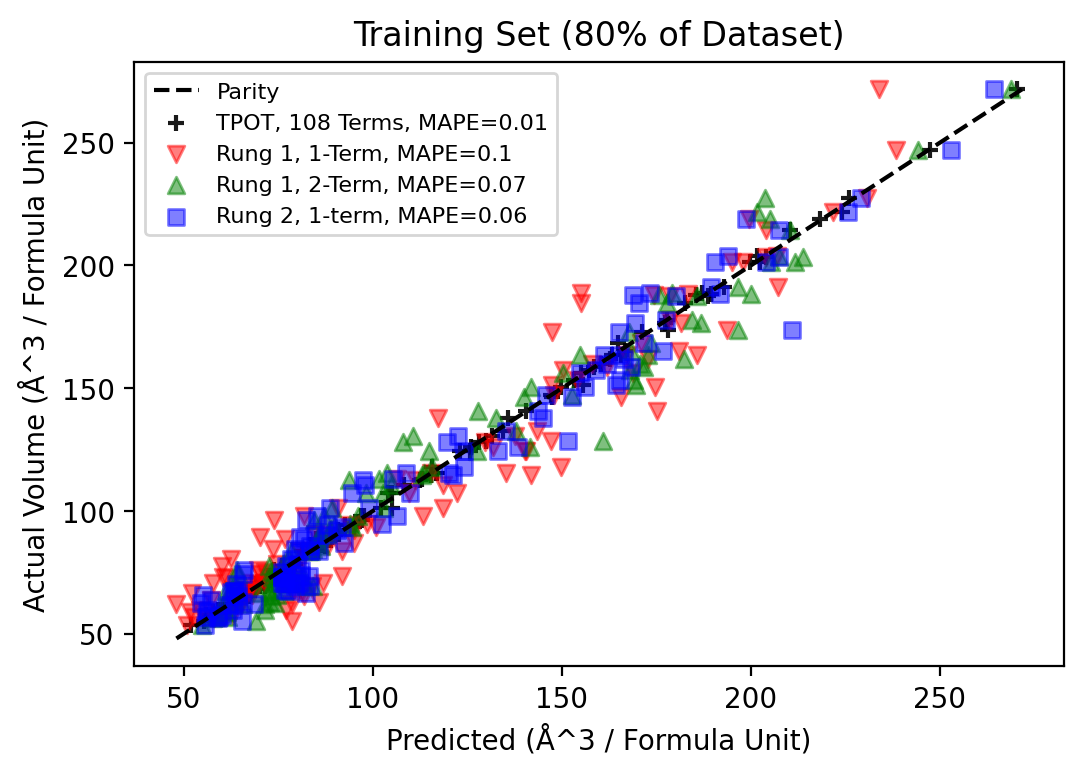

In [10]:
tpot_mape = np.round(sklearn.metrics.mean_absolute_percentage_error(y_true=unscale(train_y),  y_pred=unscale(train_pred_y)),2)
r1_1t_mape = np.round(sklearn.metrics.mean_absolute_percentage_error(y_true=unscale(train_y), y_pred=unscale(data_train_scaled_sisso["r1_1term"])), 2)
r1_2t_mape = np.round(sklearn.metrics.mean_absolute_percentage_error(y_true=unscale(train_y), y_pred=unscale(data_train_scaled_sisso["r1_2term"])), 2)
r2_1t_mape = np.round(sklearn.metrics.mean_absolute_percentage_error(y_true=unscale(train_y), y_pred=unscale(data_train_scaled_sisso["r2_1term"])), 2)

alphas = (0.9, 0.5, 0.5, 0.5)
markers = '+v^s'
colors=('black','red', 'green', 'blue')
labels=(f"TPOT, 108 Terms, MAPE={tpot_mape}",
        f"Rung 1, 1-Term, MAPE={r1_1t_mape}",
        f"Rung 1, 2-Term, MAPE={r1_2t_mape}",
        f"Rung 2, 1-term, MAPE={r2_1t_mape}")

DigitalEcosystem.utils.figures.create_multi_parity_plot(ytrue=unscale(train_y), 
                                                        series_to_plot = map(unscale, (train_pred_y, 
                                                                                       data_train_scaled_sisso['r1_1term'],
                                                                                       data_train_scaled_sisso['r1_2term'],
                                                                                       data_train_scaled_sisso['r2_1term'])
                                                                            ),
                                                        markers=markers,
                                                        alphas=alphas,
                                                        colors=colors,
                                                        labels=labels,
                                                        is_train=True)

## Test-Set
Below, we plot the Training set results for:
1. The TPOT model (Black + symbols)
2. The SISSO Rung1, 1-Term Model (Red Nablas / Upside-Down Triangles)
3. The SISSO Rung1, 2-Term Model (Green Deltas / Rightside-Up Triangles)
4. The SISSO Rung2, 1-Term Model (Blue Squares)

As a guide to the eye, parity is also drawn as a dashed black line.

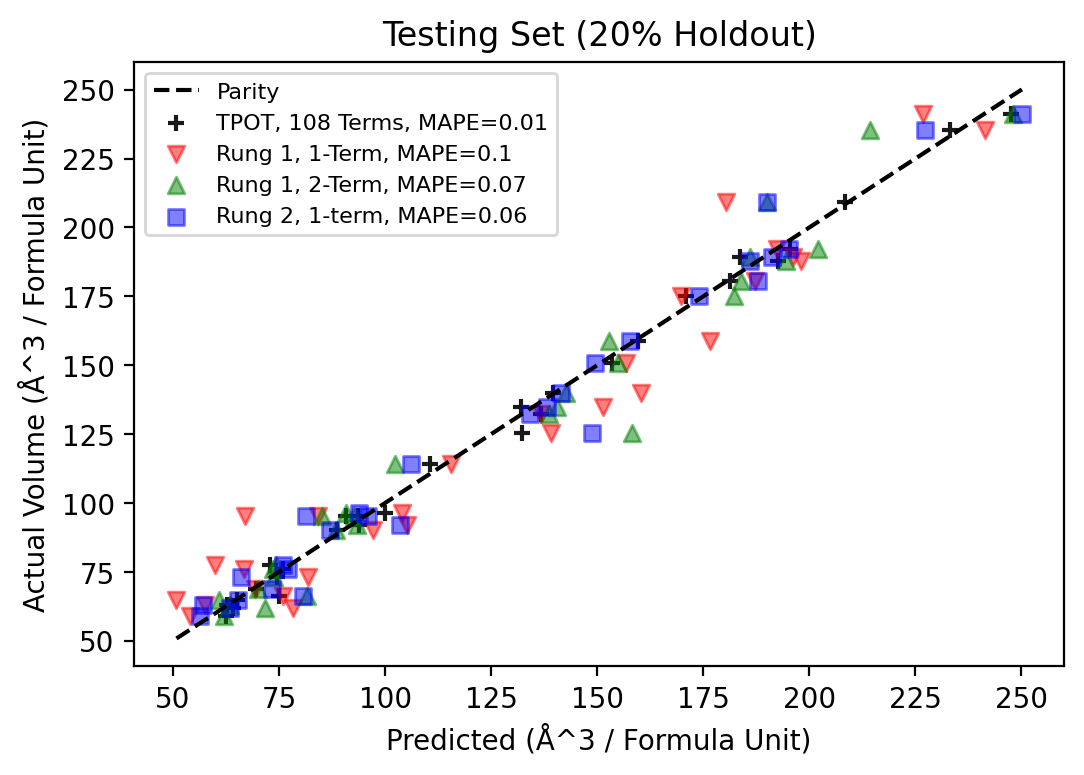

In [11]:
DigitalEcosystem.utils.figures.create_multi_parity_plot(ytrue=unscale(test_y), 
                                                        series_to_plot = map(unscale, (test_pred_y, 
                                                                                       data_test_scaled_sisso['r1_1term'],
                                                                                       data_test_scaled_sisso['r1_2term'],
                                                                                       data_test_scaled_sisso['r2_1term'])
                                                                            ),
                                                        markers=markers,
                                                        alphas=alphas,
                                                        colors=colors,
                                                        labels=labels,
                                                        is_train=False)

# Conclusions

Overall, we find that SISSO creates models that are much simpler than the TPOT pipeline, while being nearly as performant. Generally, they seem to rely heavily on atomic volume descriptors.

Although this may initially seem like an obvious result (as naturally, the crystal cell should correlated with the atomic volumes contained within), keep in mind that SISSO took in no other information about this result. Moreover, it generates easy-to-interpret linear models that give the user "knobs" that can be turned to effect some result.

Contrast with the TPOT model, which contains a decision tree followed by some postprocessing followed by ridge regression. This model is essentially a black box - although the decision trees are generally interpretable, we're also heavily postprocessing it. Morevoer, a decision tree is an interpolative model, which means we'd be unable to extrapolate. The decision tree also takes in over 100 features.

Contrary to this limitation, the SISSO model will extrapolate, takes in just 2-4 features (depending on the rung and number of terms), and results to something that's very close to the conventional wisdom a chemist might offer.

Overall, although the TPOT model performs *slightly* better, the SISSO model has more utility if one seeks to obtain physical insight.